https://stepik.org/lesson/432289/step/1?unit=717339


In [ ]:
import os

import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, utils, datasets

sns.set(font_scale=1.4, style="whitegrid")

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

# Загрузка датасета


In [ ]:
classes = ("plane", "car", "bird", "cat",
           "deer", "dog", "frog", "horse", "ship", "truck")

def get_dataloaders(batch_size):
    
    ## описываем трансформацию данных
    transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    
    ## загружаем датасеты и делаем даталоадеры
    trainset = datasets.CIFAR10(root="./data", train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    testset = datasets.CIFAR10(root="./data", train=False,
                                           download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    
    return trainloader, testloader

# Код обучения

In [ ]:
## обучение и сохранение лоссов/акьюраси
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    ## списки для лоссов и акьюраси
    train_losses = []
    val_losses = []
    valid_accuracies = []
    for epoch in range(epochs):
        
        ## тренируем модель, запоминаем лоссы на трейне
        model.train()
        loss_sum = 0
        for xb, yb in tqdm(train_dl):
            ## из трейна берем батч: фичи и таргет
            xb, yb = xb.to(device), yb.to(device)
            
            loss = loss_func(model(xb), yb)
            loss_sum += loss.item()
            
            loss.backward()  ## вычисляем градиенты
            opt.step()  ## изменяем веса
            opt.zero_grad()  
            ## не забываем нде-нибудь обнулить градиенты 
            ## (главное не между backward и step)
        train_losses.append(loss_sum / len(train_dl))

        ## используем модель на валидации, запоминаем лоссы и акьюраси 
        model.eval()
        ## выключает режим обучения. Например, выключает дропаут, 
        ## заставляет батчнорм использовать накопленную статистику
        loss_sum = 0
        correct = 0  ## количество правильных ответов
        num = 0  ## общее количество примеров
        with torch.no_grad():  ## выключает вычисление градиентов
            for xb, yb in tqdm(valid_dl):
                xb, yb = xb.to(device), yb.to(device)
                
                probs = model(xb)
                loss_sum += loss_func(probs, yb).item()
                _, preds = torch.max(probs, axis=-1)
                correct += (preds == yb).sum().item()
                num += len(xb)
                
        val_losses.append(loss_sum / len(valid_dl))
        valid_accuracies.append(correct / num)
        
    return train_losses, val_losses, valid_accuracies

In [ ]:
## рисовалка процесса обучения
def plot_trainig(train_losses, valid_losses, valid_accuracies):
    plt.figure(figsize=(12, 9))
    plt.subplot(2, 1, 1)
    plt.xlabel("epoch")
    plt.plot(train_losses, label="train_loss")
    plt.plot(valid_losses, label="valid_loss")
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.xlabel("epoch")
    plt.plot(valid_accuracies, label="valid accuracy")
    plt.legend()

# Создание модели

In [ ]:
class ModelBatchNorm(nn.Module):  ## наследуемся от nn.Module
    def __init__(self):
        super(ModelBatchNorm, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        ## feature extractor
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.bn2 = nn.BatchNorm2d(16)
        ## классификатор
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 5x5 image dimension
        self.bn3 = nn.BatchNorm1d(120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.bn1(F.max_pool2d(F.relu(self.conv1(x)), (2, 2)))
        x = self.bn2(F.max_pool2d(F.relu(self.conv2(x)), 2))
        x = x.view(x.shape[0], -1)  ## делаем одномерный "массив"?
        x = self.bn3(F.relu(self.fc1(x)))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Обучение

Files already downloaded and verified
Files already downloaded and verified


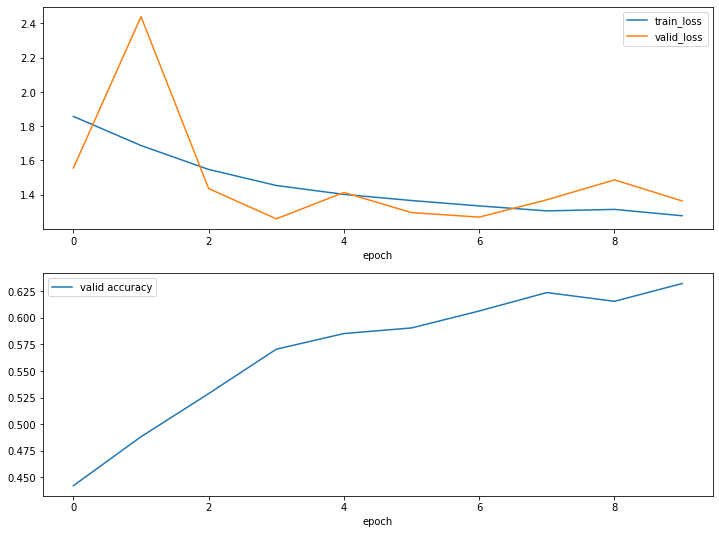

In [ ]:
model = ModelBatchNorm().to(device)

## задаем лосс-функцию и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

## используем написанные (не)нами функции
info = fit(10, model, criterion, optimizer, *get_dataloaders(4))
plot_trainig(*info)